In [1]:
import os
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
BTCNN_PATH = os.path.join(ROOT_PATH, "btcnn/src/btcnn")
HBO_BENCH_PATH = os.path.join(ROOT_PATH, "hbo_bench/src/hbo_bench")
EXPERIMENT_PATH = os.getcwd()
ARTIFACTS_PATH = os.path.join(EXPERIMENT_PATH, "artifacts")

In [2]:
from collections import defaultdict
from json import load, dumps, dump

from tqdm import tqdm
import random
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from hbo_bench.utils import get_logical_tree, get_full_plan, get_selectivities, extract_list_info
from hbo_bench.oracle import Oracle, OracleRequest, TIMEOUT
from hbo_bench.data_config import HINTSETS, DOPS, HINTS, DEFAULT_HINTSET
from hbo_bench.data_types import ExplainNode
from hbo_bench.vectorization import extract_vertices_and_edges, ALL_FEATURES
from hbo_bench.dataset import WeightedBinaryTreeDataset, weighted_binary_tree_collate

from btcnn.regressor import BinaryTreeRegressor
from btcnn.layers import *

In [3]:
in_channels = len(ALL_FEATURES)

todo: test that model can be loaded; checklosses; rename models and experiments; iterate over architectures; iterate over data splits, check assert for consistency

# *Are convolution layers useful?*

Let us verify that convolutional layers indeed help to better represent queries, simplifying the further modelling task. To do this, we will compare the results of training neural networks with different complexity ratios between the convolution and regression parts.

In [4]:
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [242]:
def convert_name(name):
    name = name.replace('_', ', ')
    pattern = r'(?<=[a-z])(?=[A-Z])'
    return re.sub(pattern, ' ', name).replace("BTCNN", "TCNN")

In [243]:
convert_name("SmallBTCNN_MediumFCNN_InstanceNormalisation")

'Small TCNN, Medium FCNN, Instance Normalisation'

In [244]:
def get_groupped_curves(clearml_data):
    group_to_list_x = defaultdict(list)
    group_to_list_y = defaultdict(list)
    for curve in clearml_data:
        group_to_list_x[curve['name']].append(curve['x'])
        group_to_list_y[curve['name']].append(curve['y'])
    return group_to_list_x, group_to_list_y

In [245]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_curves(
    clearml_data, 
    logscale=False, 
    skip_first_epocs=True, 
    start_point=0,
    end_point=60,
    figsize=(12, 6),
    label_fontsize=18, 
    linewidth=4,
    scattersize=2,
    xlabel="",
    ylabel="",
    title_fontsize=18, 
    tick_label_fontsize=18, 
    legend_fontsize=24, 
    save_name=None,
):
    sns.set_style("ticks")
    sns.set_palette("deep")

    fig, ax = plt.subplots(figsize=figsize)
    
    group_to_list_x, group_to_list_y = get_groupped_curves(clearml_data)
    for i, group_name in enumerate(group_to_list_x.keys()):
        list_x, list_y = group_to_list_x[group_name], group_to_list_y[group_name]
        x = list_x[0]

        is_it_train_data = len(list_x[0]) == 300 + 1 or len(list_x[0]) == 150 + 1
        if is_it_train_data:
            x = x[::5]
            list_y = [el[::5] for el in list_y]
        
        x = x[start_point:end_point]
        list_y = [el[start_point:end_point] for el in list_y]
            
        if logscale:
            mean_y = np.mean(np.log10(np.array(list_y)), axis=0)
        else:
            mean_y = np.mean(np.array(list_y), axis=0)
        
        color = sns.color_palette("deep")[i % len(sns.color_palette("deep"))]

        ax.scatter(x, mean_y, alpha=1.0, linewidth=scattersize, label=group_name, color=color)
        ax.plot(x, mean_y, alpha=0.5, linewidth=linewidth, color=color)
        
    ax.grid(True, which='both', linestyle='--', linewidth=0.2)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel + (" (logscale)" if logscale else ""), fontsize=label_fontsize)
    ax.legend(loc="best", fontsize=legend_fontsize)
    ax.tick_params(axis='x', labelsize=tick_label_fontsize)
    ax.tick_params(axis='y', labelsize=tick_label_fontsize)

    plt.tight_layout()
    if save_name:
        plt.savefig(
            f"{ARTIFACTS_PATH}/{save_name}", 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight',
            pad_inches=0
        )
    plt.show()

In [248]:
def extract_sizes_from_name(name):
    name_wo_run = re.search(r'(.*?)_(\d+)$', name).group(1)
    name_wo_run = name_wo_run.replace('_', ', ')
    pattern = r'([a-z])([A-Z])'
    formatted_name = re.sub(pattern, r'\1 \2', name_wo_run)
    components = formatted_name.split(', ')
    formatted_components = ', '.join(components[:2])
    return formatted_components.replace("BTCNN", "TCNN")    

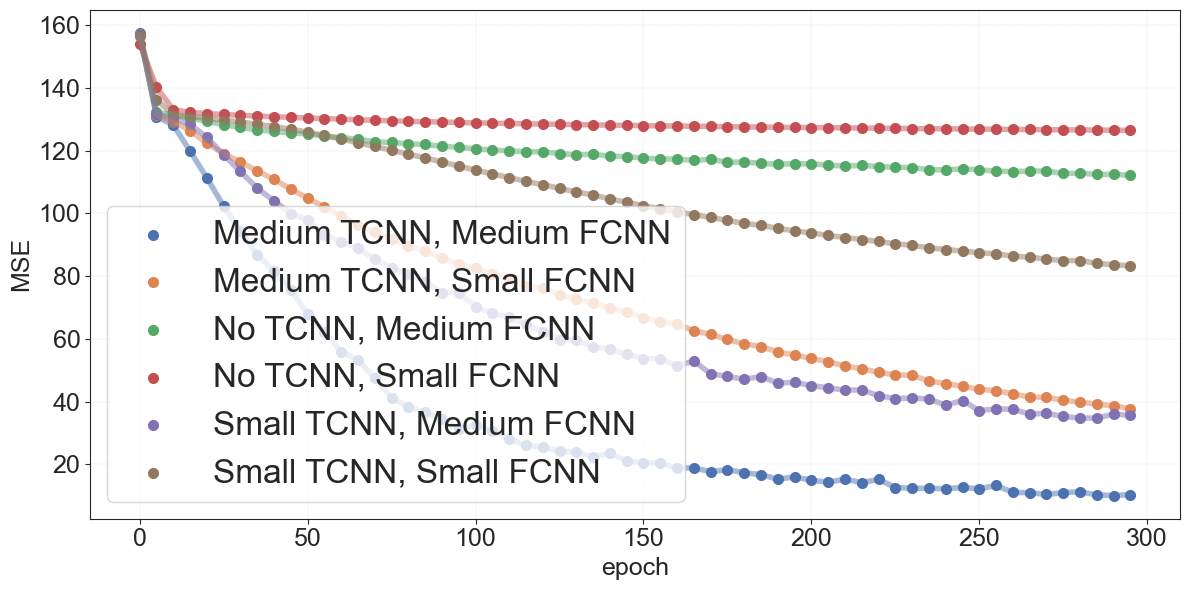

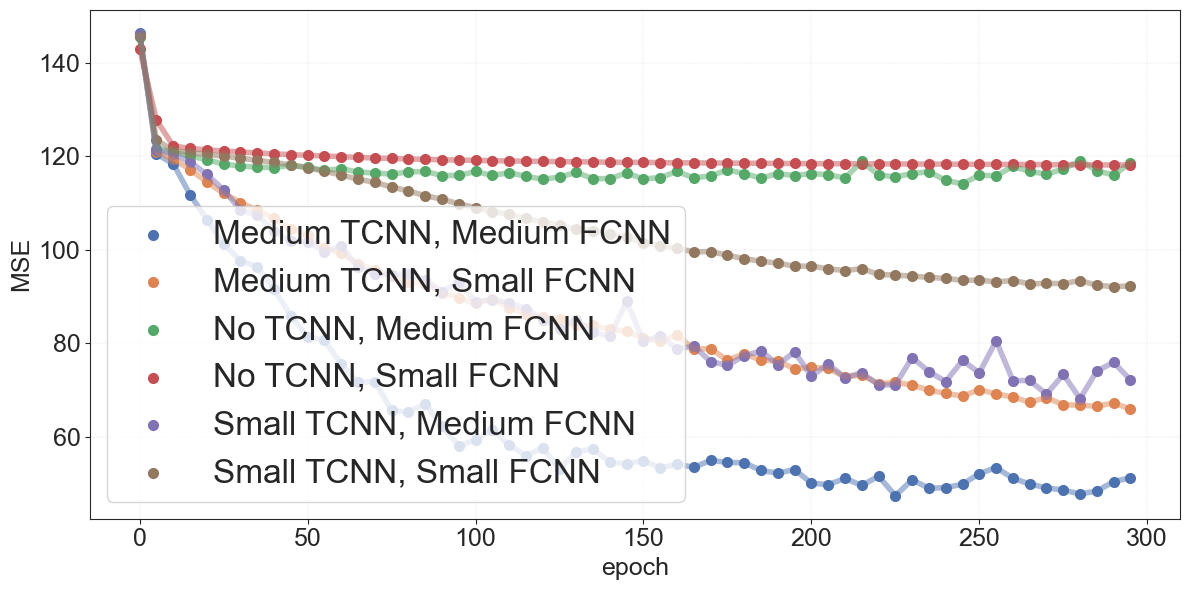

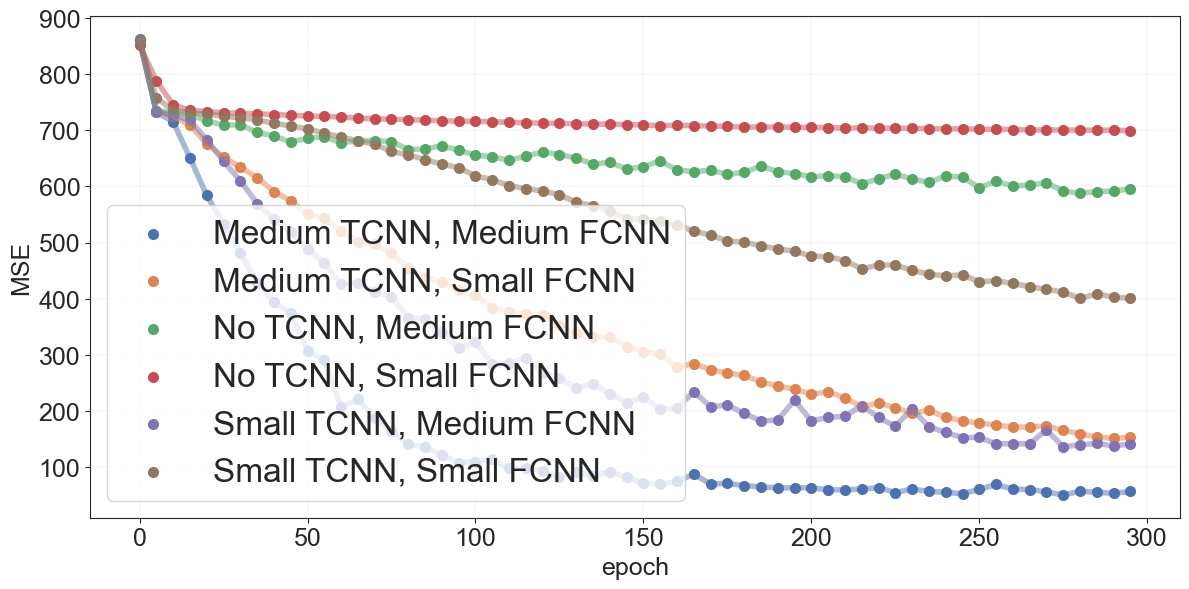

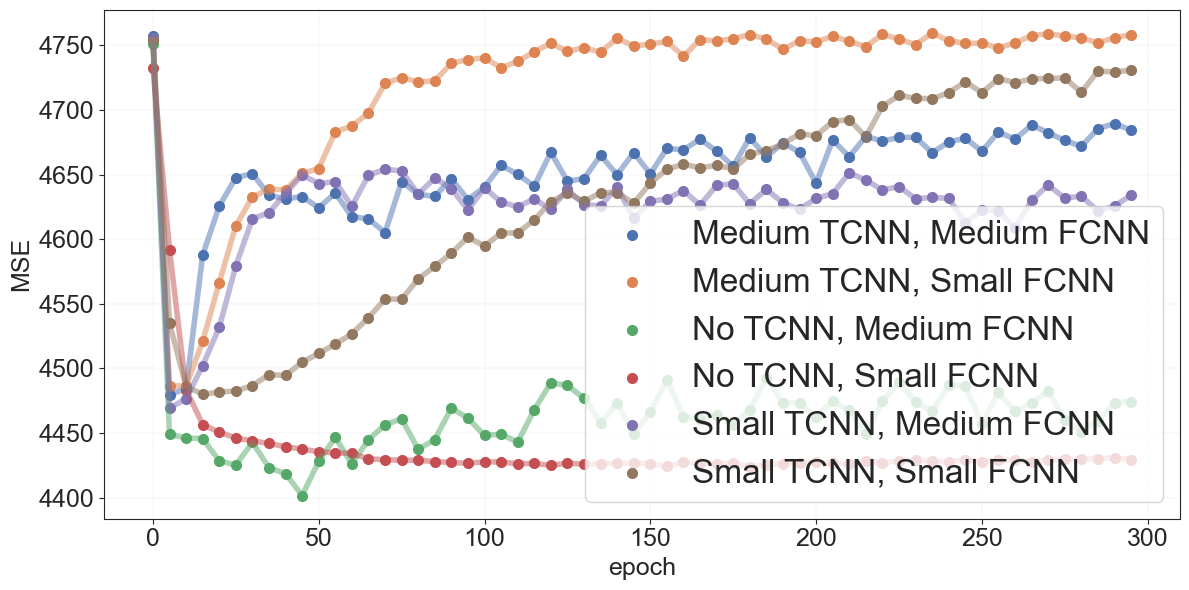

In [251]:
for loss_type in ["train", "val", "test", "ood"]:
    with open(f"{ARTIFACTS_PATH}/losses/medium_models/{loss_type}.json", "r") as f:
        clearml_data = load(f)
        for l in clearml_data:
            l['name'] = extract_sizes_from_name(l['name'])
    plot_curves(clearml_data, xlabel="epoch", ylabel="MSE", logscale=False, start_point=0, save_name=f"medium_models_{loss_type}.pdf")

The advantages of having binary tree convolutional layers are obvious. So it makes sense to select the architecture further.

# *Which model architecture is the best?*

In [26]:
def extract_norm_layer_from_name(name):
    norm_layer = name.split('_')[-2]
    if norm_layer == "BigFCNN":
        norm_layer = "No Normalisation" 
    return norm_layer

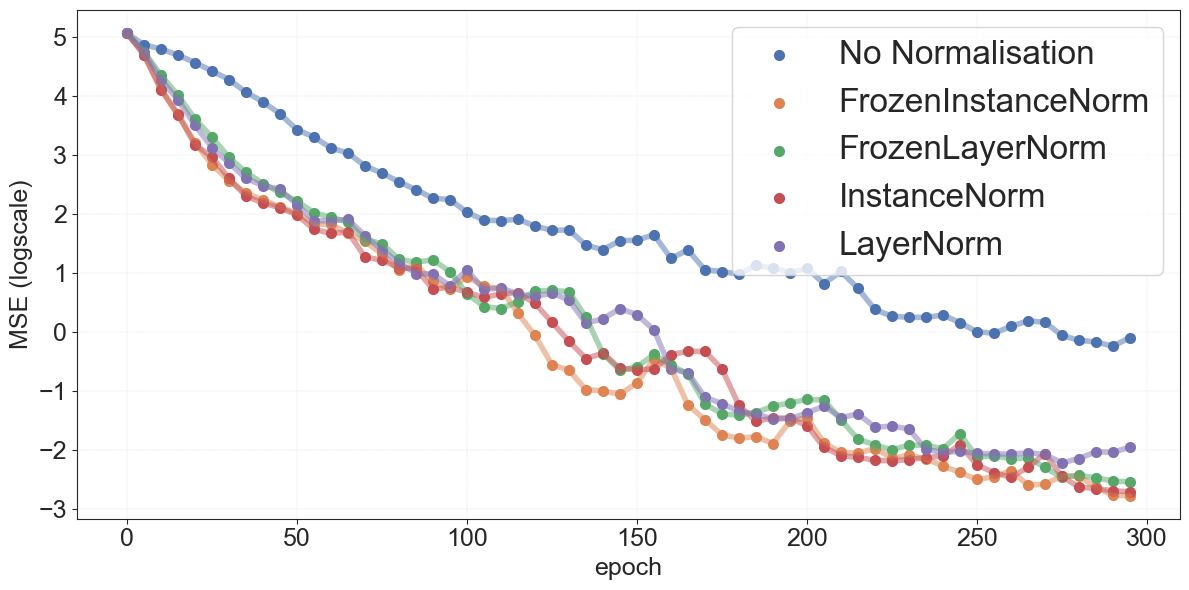

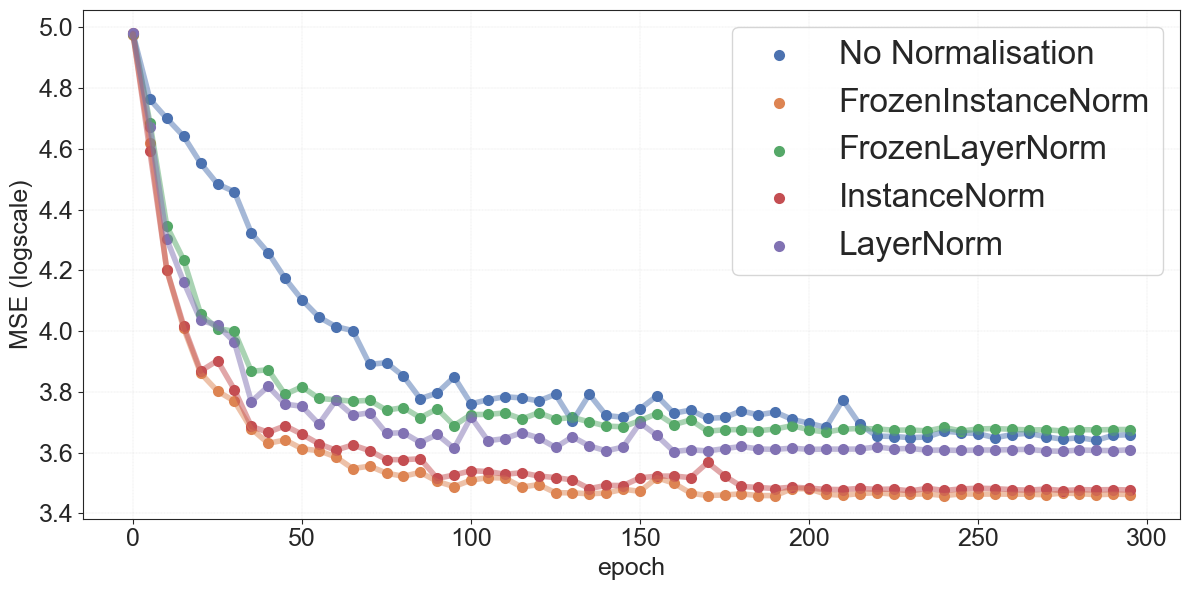

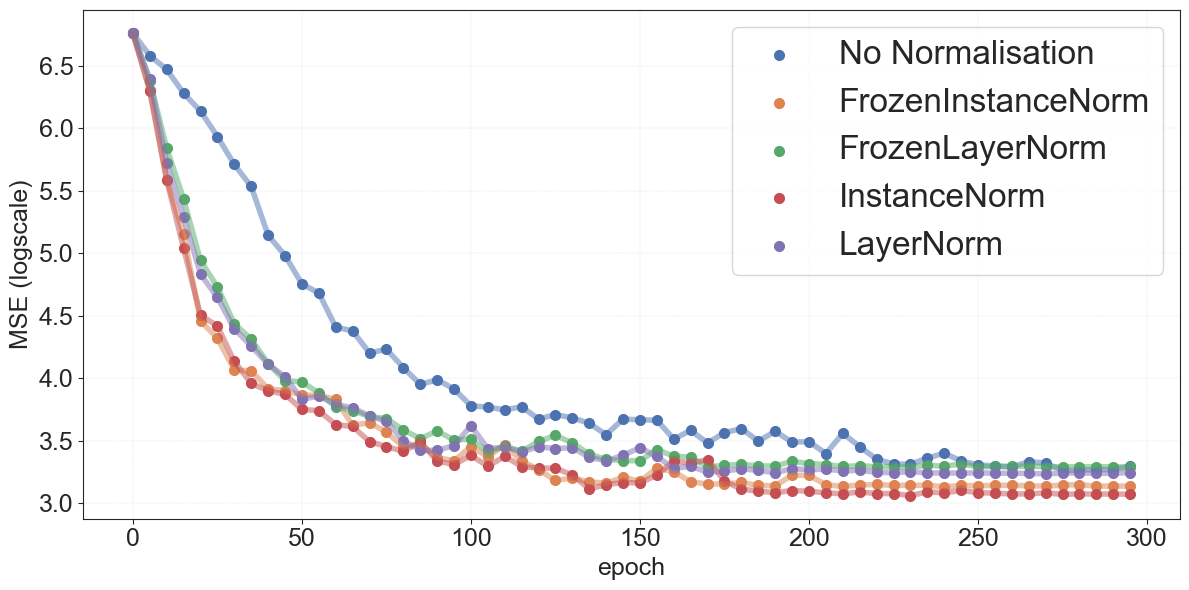

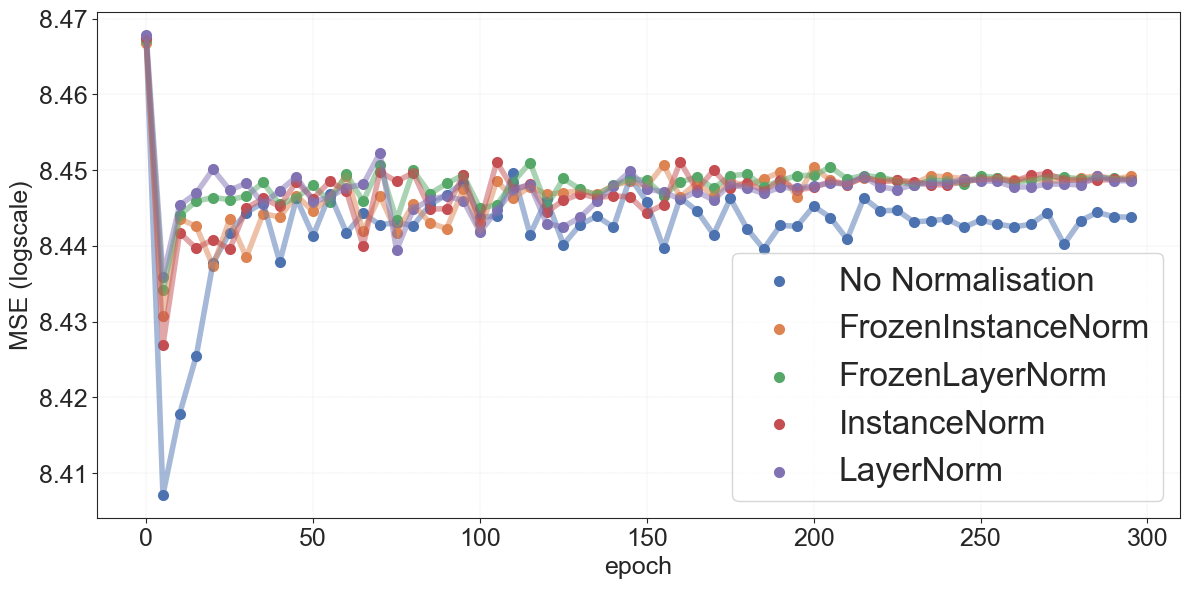

In [27]:
for loss_type in ["train", "val", "test", "ood"]:
    with open(f"{ARTIFACTS_PATH}/losses/big_models/{loss_type}.json", "r") as f:
        clearml_data = load(f)
        for l in clearml_data:
            l['name'] = extract_norm_layer_from_name(l['name'])
    plot_curves(clearml_data, xlabel="epoch", ylabel="MSE", logscale=True, start_point=0, save_name=f"big_models_{loss_type}.pdf")


`InstanceNorm` slightly outperforms other normalistaion layers.

# *Performance on noised data*

In [28]:
def extract_noise_type(name):
    match = re.search(r"\[(.*?)\]", name)
    if not match:
        return "No Noise"
    result = match.group(1)
    if result == "all":
        return "Noised Operations, Statistics"
    elif result == "ops":
        return "Noised Operations"
    else:
        return "Noised Statistics"

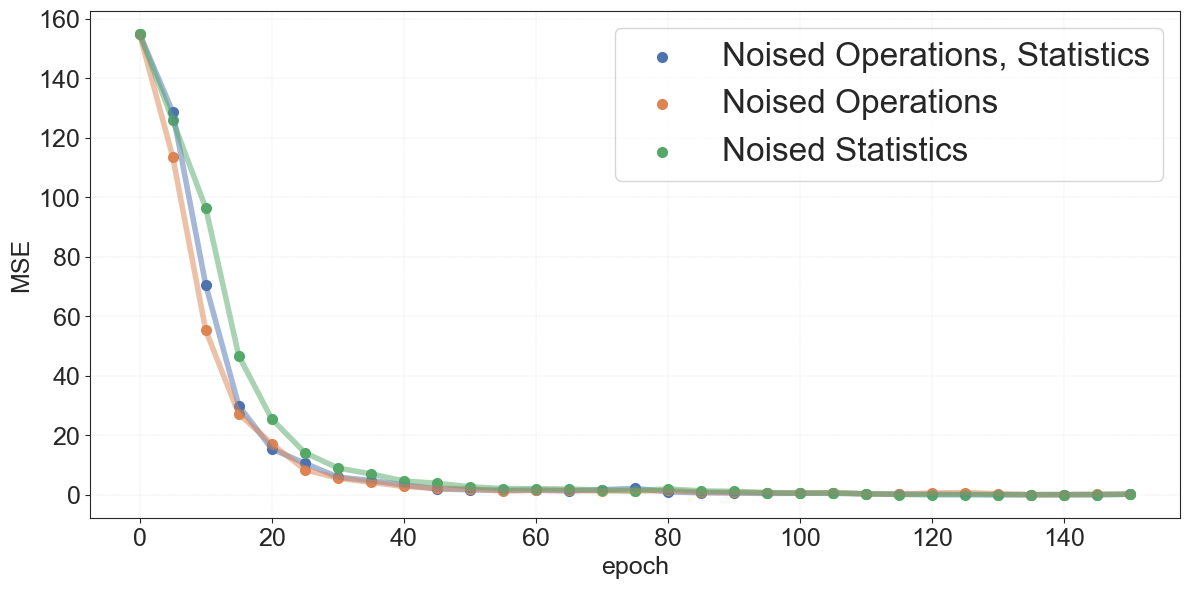

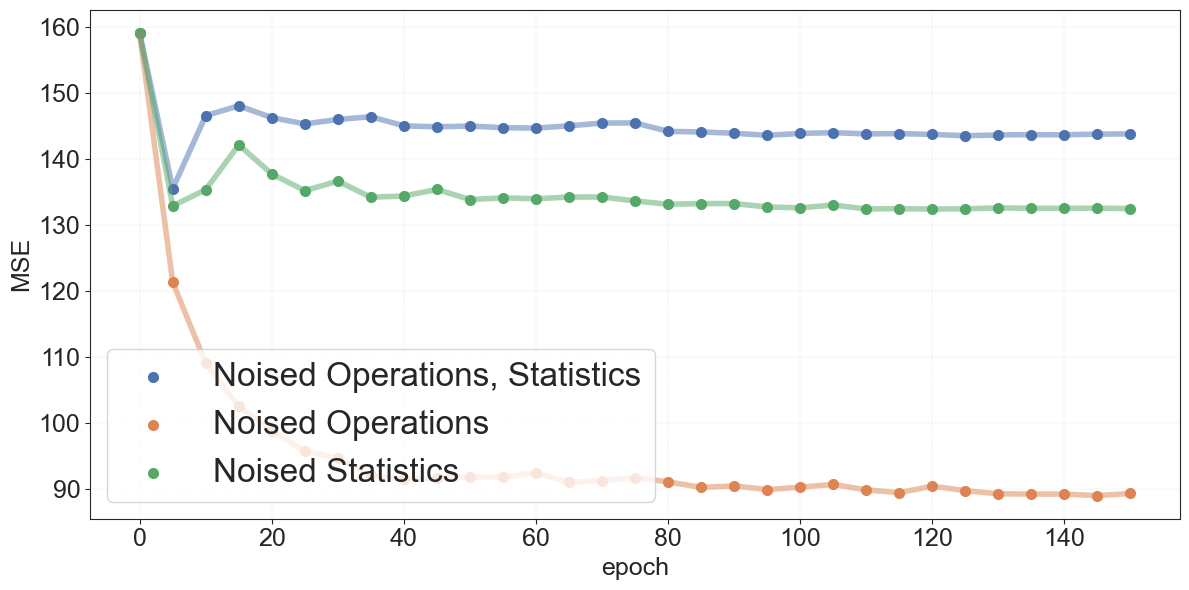

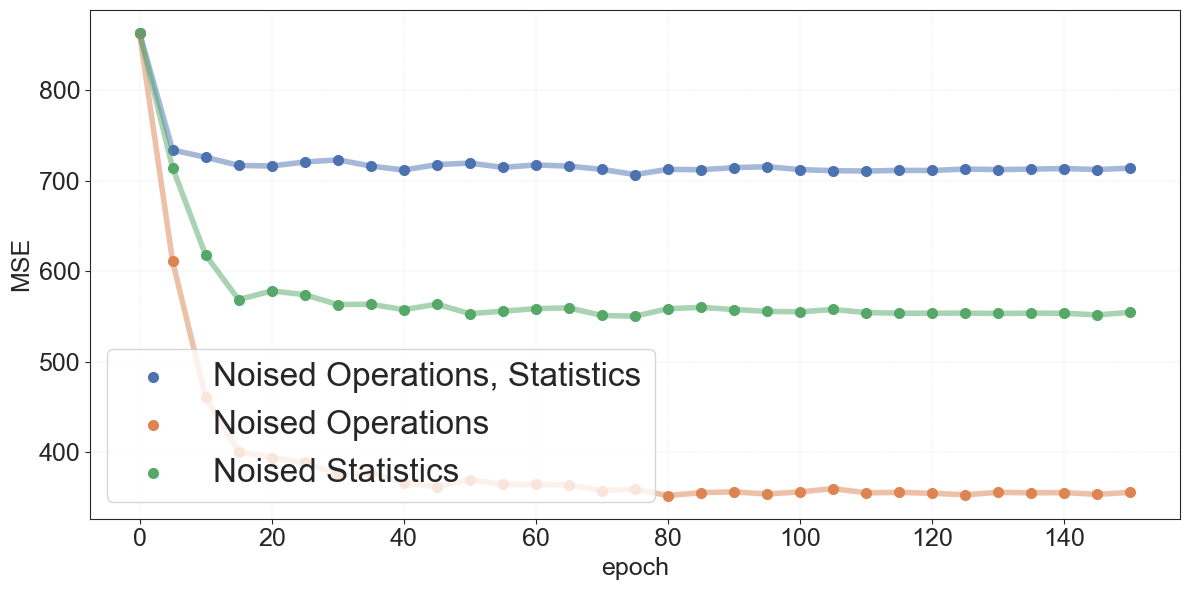

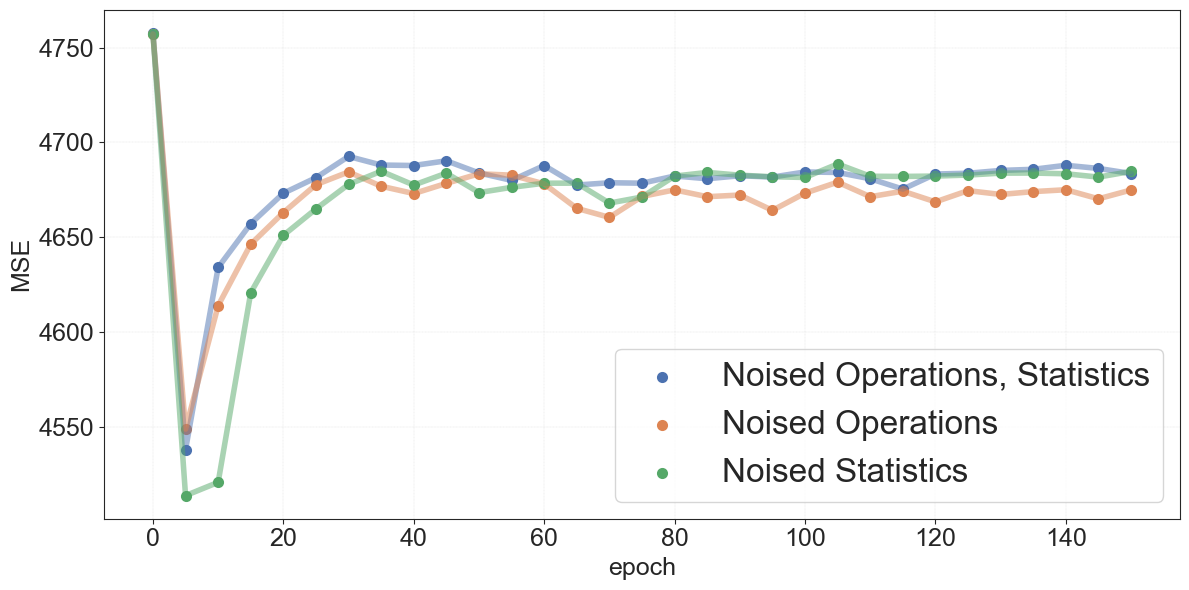

In [29]:
for loss_type in ["train", "val", "test", "ood"]:
    with open(f"{ARTIFACTS_PATH}/losses/noised_data/{loss_type}.json", "r") as f:
        clearml_data = load(f)
        for l in clearml_data:
            l['name'] = extract_noise_type(l['name'])
    plot_curves(clearml_data, xlabel="epoch", ylabel="MSE", logscale=False, start_point=0, save_name=f"big_models_{loss_type}_on_noised_data.pdf")


As expected - there is no generalisation when training on full noise, the network only memorises examples.
When the statistical channels are noisy, it becomes much more difficult for the NN to predict the execution time. Not surprisingly, because these statistics are estimates of the size of the data being processed, derived from the cardinality model. They take into account the statistics in the database and greatly simplify the modelling of runtime dependence. In a sense, the NN only trains the correct cost GUQs.
Note, that if both operations and statistics are available, then NN model can learn contextual dependency between plan and time.

**Conclusion.** The working hypothesis is that the trained NN actually plays the role of a complex (with contextual by operations dependency) **cost corrector model**, where a time scale is used instead of an abstract cost scale. In this case, the question arises:

*"Is the quality of the trained model on validation / test set better than the quality of cost model?"*

# Complex Landscape

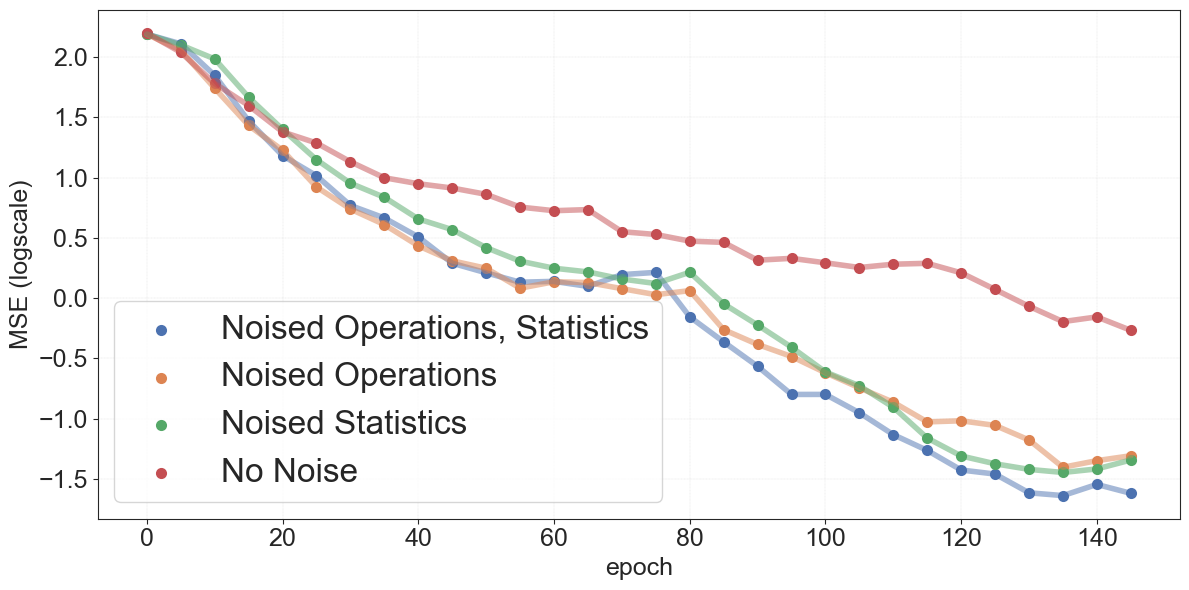

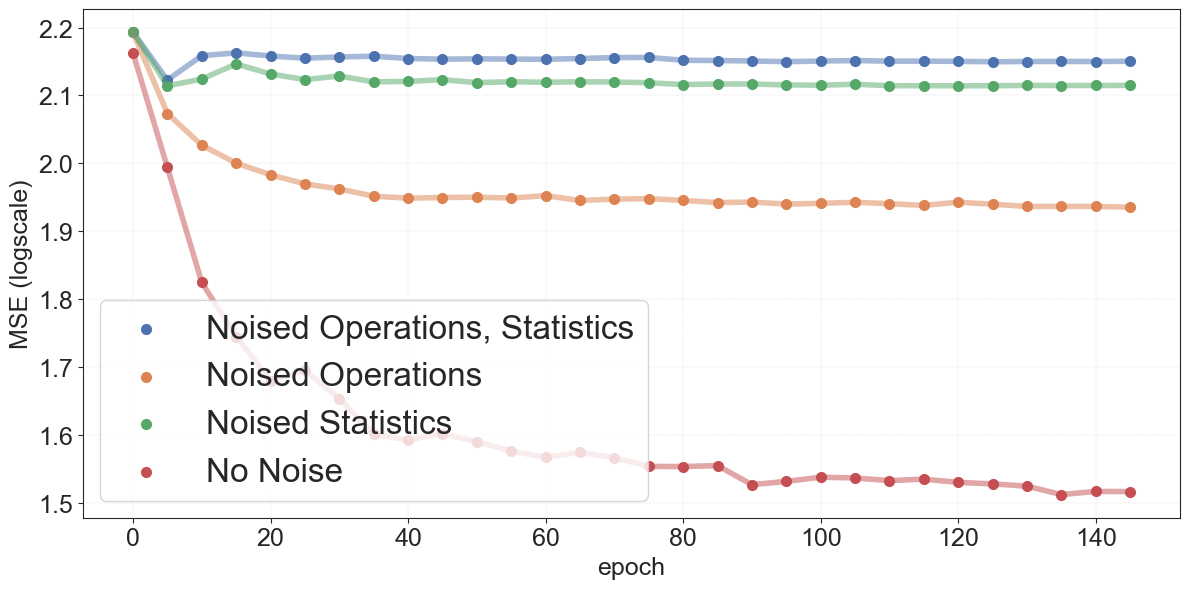

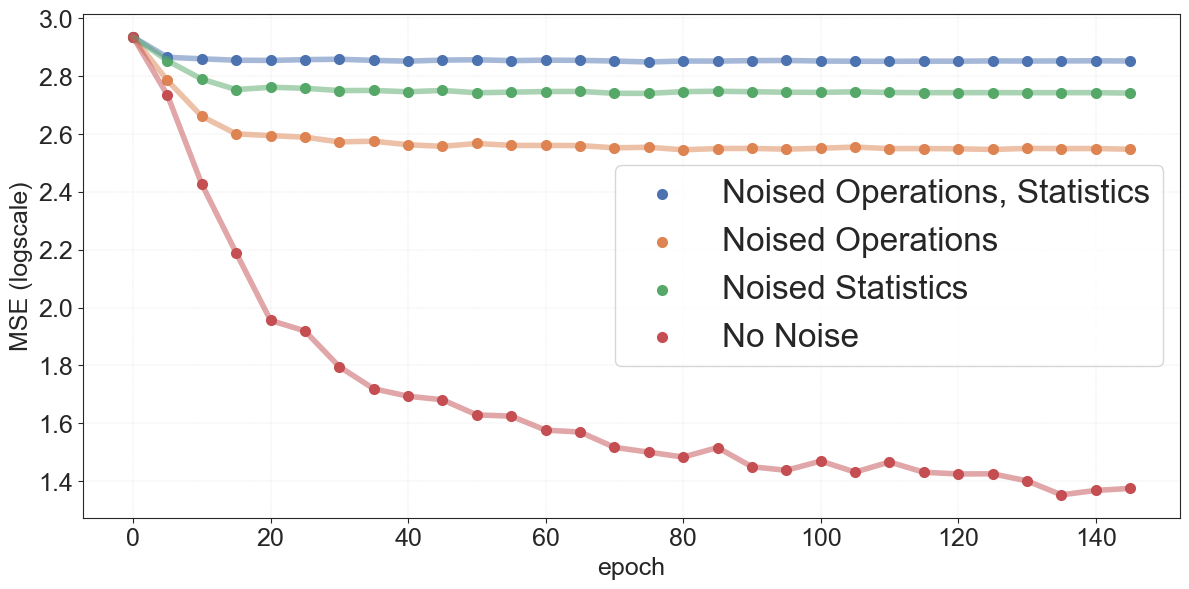

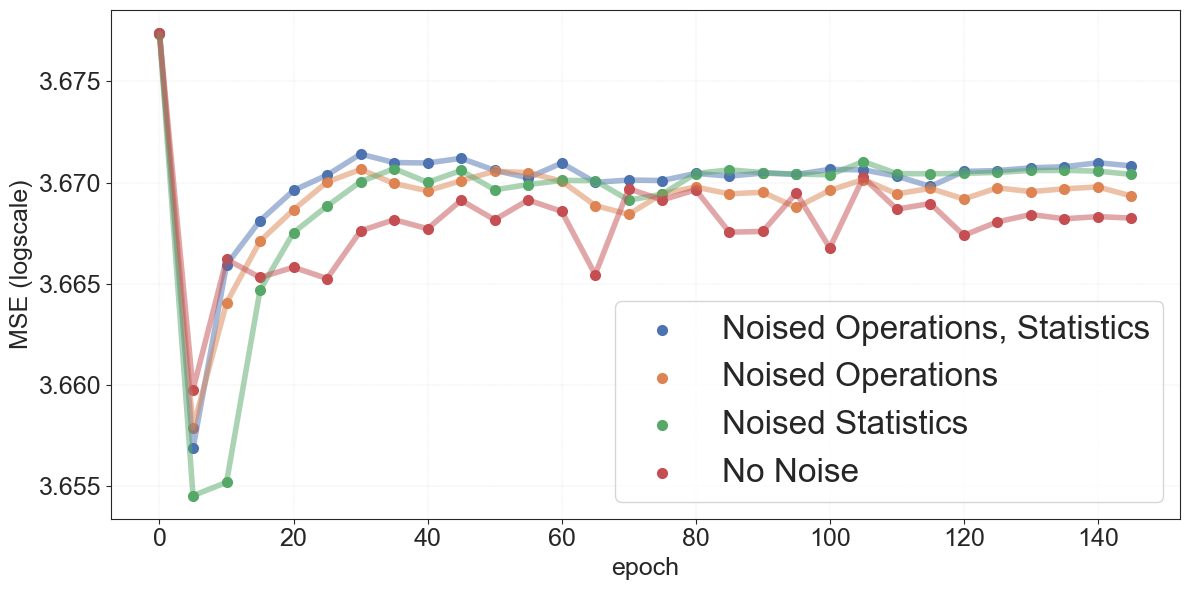

In [39]:
for loss_type in ["train", "val", "test", "ood"]:
    with open(f"{ARTIFACTS_PATH}/losses/noised_data/{loss_type}.json", "r") as f:
        clearml_data = load(f)
    with open(f"{ARTIFACTS_PATH}/losses/big_models/{loss_type}.json", "r") as f:
        clearml_data += load(f)[-10:-5]
    for l in clearml_data:
        l['name'] = extract_noise_type(l['name'])
    plot_curves(clearml_data, xlabel="epoch", ylabel="MSE", end_point=30, logscale=True, start_point=0, save_name=f"{loss_type}_complex_landscape.pdf")

We see that replacing the tree information with full noise even makes the optimisation problem easier - this is a clear signal that the natural landscape of the loss function, which is given by real statistics and plans, is extremely difficult to be approximated.

# [code only for paper]

## multiple plots

In [231]:
def plot_curves_on_axes(
    ax, 
    clearml_data, 
    logscale=False, 
    skip_first_epocs=True, 
    start_point=0,
    end_point=60,
    label_fontsize=18, 
    linewidth=4,
    scattersize=2,
    xlabel="",
    ylabel="",
    title_fontsize=18, 
    tick_label_fontsize=18,
    color_num=None,
):
    sns.set_style("ticks")
    sns.set_palette("deep")

    group_to_list_x, group_to_list_y = get_groupped_curves(clearml_data)
    for i, group_name in enumerate(group_to_list_x.keys()):
        list_x, list_y = group_to_list_x[group_name], group_to_list_y[group_name]
        x = list_x[0]

        is_it_train_data = len(list_x[0]) == 300 + 1 or len(list_x[0]) == 150 + 1
        if is_it_train_data:
            x = x[::5]
            list_y = [el[::5] for el in list_y]
        
        x = x[start_point:end_point]
        list_y = [el[start_point:end_point] for el in list_y]
            
        if logscale:
            ax.set_yscale('log')
        mean_y = np.mean(np.array(list_y), axis=0)
        
        if color_num:
            color = sns.color_palette("deep")[color_num % len(sns.color_palette("deep"))]
        else:
            color = sns.color_palette("deep")[i % len(sns.color_palette("deep"))]
        


        ax.scatter(x, mean_y, alpha=1.0, linewidth=scattersize, label=group_name, color=color)
        ax.plot(x, mean_y, alpha=0.5, linewidth=linewidth, color=color)
        
    ax.grid(True, which='both', linestyle='--', linewidth=0.2)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    ax.tick_params(axis='x', labelsize=tick_label_fontsize)
    ax.tick_params(axis='y', labelsize=tick_label_fontsize)

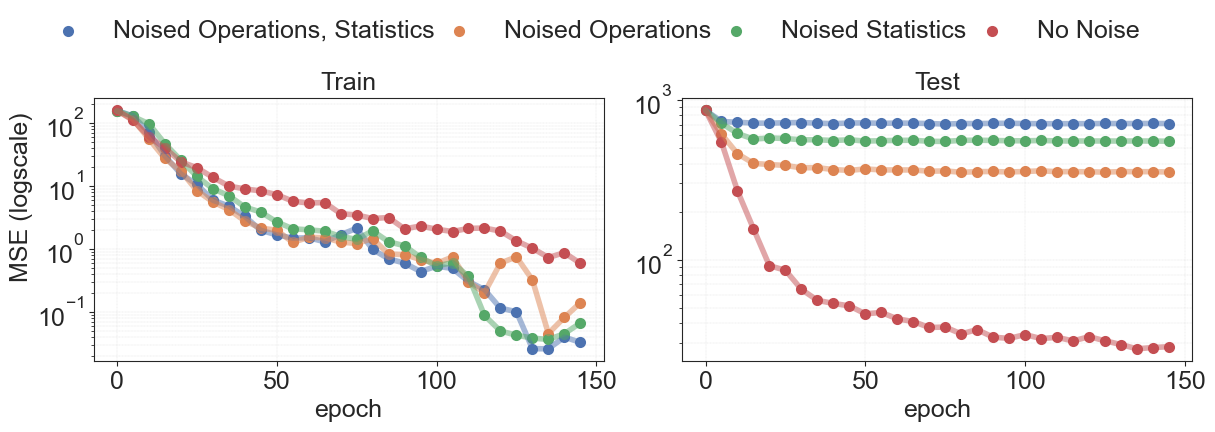

In [232]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

fig.text(-.01, 0.6, 'MSE (logscale)', va='center', rotation='vertical', fontsize=18)


for i, (loss_type, logscale, title) in enumerate([("train", True, "Train"), ("test", True, "Test")]):
    with open(f"{ARTIFACTS_PATH}/losses/noised_data/{loss_type}.json", "r") as f:
        clearml_data = load(f)
    with open(f"{ARTIFACTS_PATH}/losses/big_models/{loss_type}.json", "r") as f:
        clearml_data += load(f)[-10:-5]
    for l in clearml_data:
        l['name'] = extract_noise_type(l['name'])
    axs[i].set_title(title, fontsize=18)
    plot_curves_on_axes(axs[i], clearml_data, xlabel="epoch", ylabel="", end_point=30, logscale=logscale, start_point=0)


handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.95, 1.1), fontsize=18, ncol=4, frameon=False, columnspacing=0.001)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(
    f"{ARTIFACTS_PATH}/figures_noised_data.pdf", 
    format='pdf', 
    dpi=300, 
    bbox_inches='tight',
    pad_inches=0
)
plt.show()

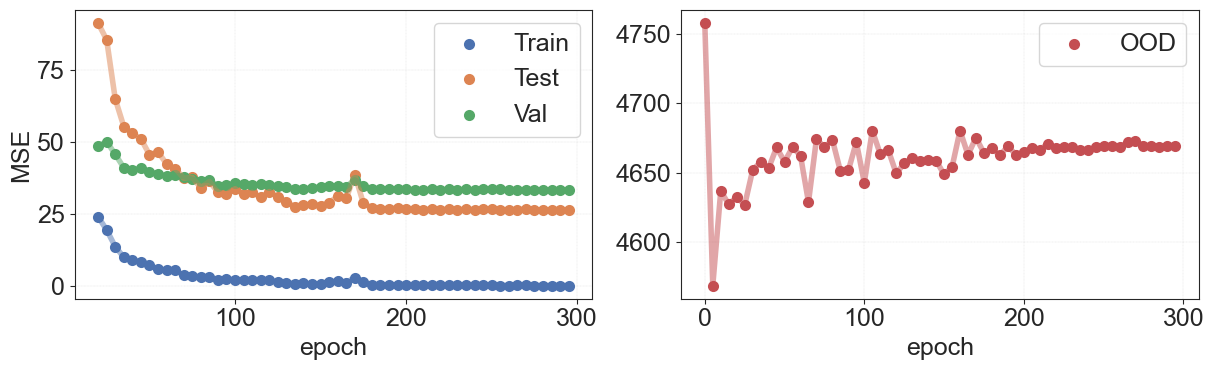

In [241]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.text(-.01, 0.55, 'MSE', va='center', rotation='vertical', fontsize=18)


clearml_data = []
for i, (loss_type, title) in enumerate([("train", "Train"), ("test", "Test"), ("val", "Val")]):
    with open(f"{ARTIFACTS_PATH}/losses/big_models/{loss_type}.json", "r") as f:
        new_data = load(f)[-10:-5]
        for l in new_data:
            l['name'] = title
        clearml_data += new_data
plot_curves_on_axes(axs[0], clearml_data, start_point=4, end_point=60, xlabel="epoch", ylabel="", logscale=False)
axs[0].legend(fontsize=18)


clearml_data = []
for i, (loss_type, title) in enumerate([("ood", "OOD")]):
    with open(f"{ARTIFACTS_PATH}/losses/big_models/{loss_type}.json", "r") as f:
        new_data = load(f)[-10:-5]
        for l in new_data:
            l['name'] = title
        clearml_data += new_data
plot_curves_on_axes(axs[1], clearml_data, start_point=0, end_point=60, xlabel="epoch", ylabel="", logscale=False, color_num=3)
axs[1].legend(fontsize=18)


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(
    f"{ARTIFACTS_PATH}/figures_generalisation.pdf", 
    format='pdf', 
    dpi=300, 
    bbox_inches='tight',
    pad_inches=0
)
plt.show()

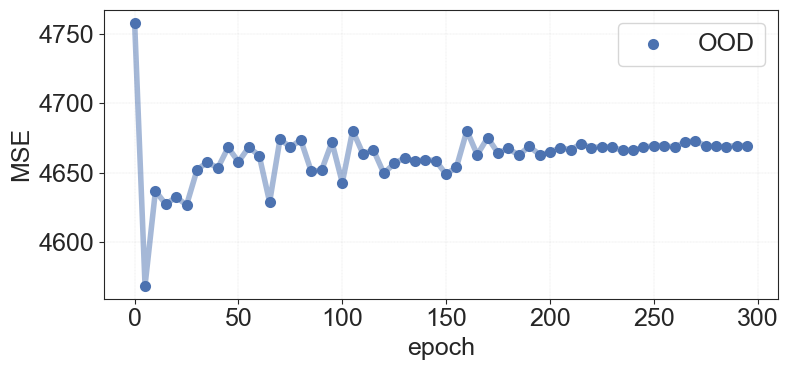

In [217]:
fig, ax = plt.subplots(figsize=(8, 4))

clearml_data = []
for i, (loss_type, title) in enumerate([("ood", "OOD")]):
    with open(f"{ARTIFACTS_PATH}/losses/big_models/{loss_type}.json", "r") as f:
        new_data = load(f)[-10:-5]
        for l in new_data:
            l['name'] = title
        clearml_data += new_data

plot_curves_on_axes(ax, clearml_data, start_point=0, end_point=60, xlabel="epoch", ylabel="MSE", logscale=False)
plt.legend(fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(
    f"{ARTIFACTS_PATH}/figures_generalisation_ood.pdf", 
    format='pdf', 
    dpi=300, 
    bbox_inches='tight',
    pad_inches=0
)
plt.show()